# SED Processing GALSEDATLAS Composite Tests
This is an extension of the previous notebook that used swire templates to create AGN composite galaxies. This notebook is extended to go further down that line, exploring more of the functionality explored using the swire templates but on a large SED template set. GALSEDATLAS is a set of SED templates that are used to model galaxies in the universe. This notebook will explore the use of these templates to create composite galaxies and test the functionality of the SED processing code.

In [6]:
# Read in all required libraries
# Import in all of the required libraries
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
import pandas as pd
import os
from astLib import astSED
import astropy.io.fits as fits
from carf import * # custom module for functions relating to the project

# So that we can change the helper functions without reloading the kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# setup all the directories we are getting our data from 

# Skirtor models
skirtor_folderpath = os.path.join('datasets', 'Templates', 'Skirtor')

# Swire templates
swire_folderpath = os.path.join('datasets', 'Templates', 'SWIRE')

# Brown templates
brown_folderpath = os.path.join('datasets', 'Templates', 'Brown', '2014','Rest')

# Filters
pb_U_path = os.path.join('datasets', 'Filters', 'Generic_Johnson.U.dat')
pb_V_path = os.path.join('datasets', 'Filters', 'Generic_Johnson.V.dat')
pb_J_path = os.path.join('datasets', 'Filters', '2MASS_2MASS.J.dat')

In [8]:
# In addition also use astSED to create filters
pb_U = astSED.Passband(pb_U_path, normalise=False)
pb_V = astSED.Passband(pb_V_path, normalise=False)
pb_J = astSED.Passband(pb_J_path, normalise=False)

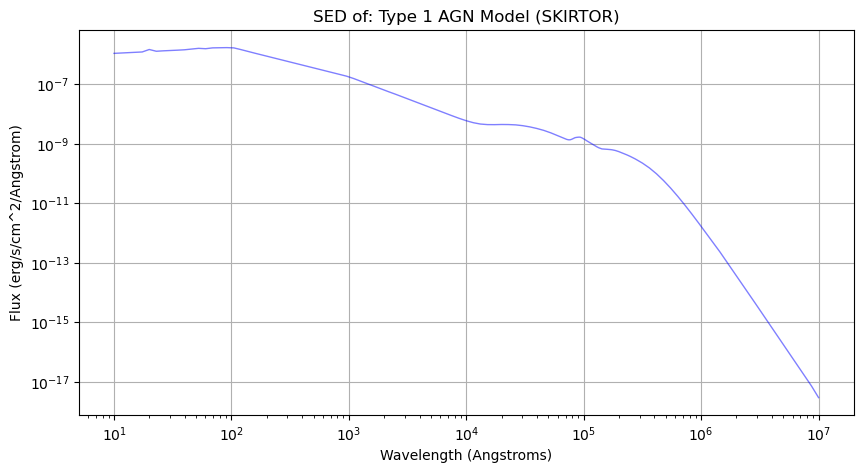

In [10]:
# 1. Type 1 AGN


agn_model, params = create_type1_skirtor_agn(skirtor_folderpath)
wl_agn = agn_model['lambda (Angstroms)']
fl_agn = agn_model['Total Flux (erg/s/cm^2/Angstrom)']
plot_galaxy_sed(wl_agn, fl_agn, "Type 1 AGN Model", "SKIRTOR")

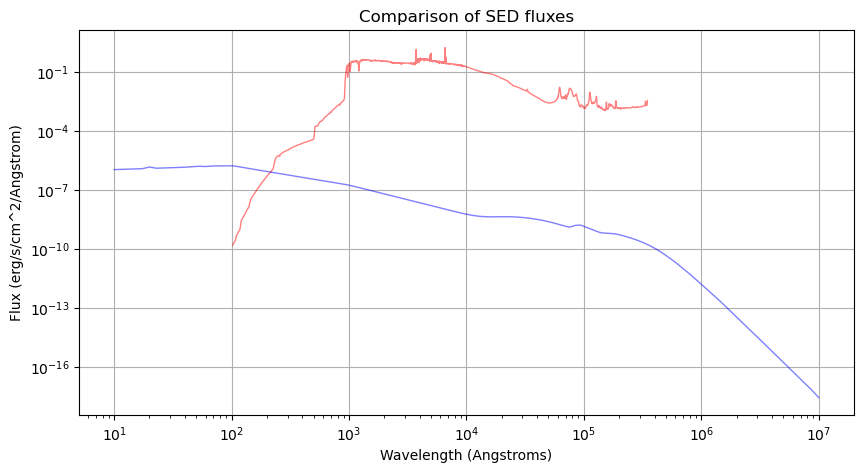

In [11]:
ngc0337_template, obj_name = read_brown_galaxy_template(brown_folderpath, 'NGC_0337')

wl_ngc0337 = ngc0337_template['lambda (Angstroms)']
fl_ngc0337 = ngc0337_template['Total Flux (erg/s/cm^2/Angstrom)']

plt.figure(figsize=(10, 5))
plt.loglog(wl_ngc0337, fl_ngc0337, color='red', linewidth=1, linestyle='-', alpha=0.5)
plt.loglog(wl_agn, fl_agn , color='blue', linewidth=1, linestyle='-', alpha=0.5)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
plt.title('Comparison of SED fluxes')
plt.grid()
plt.show()

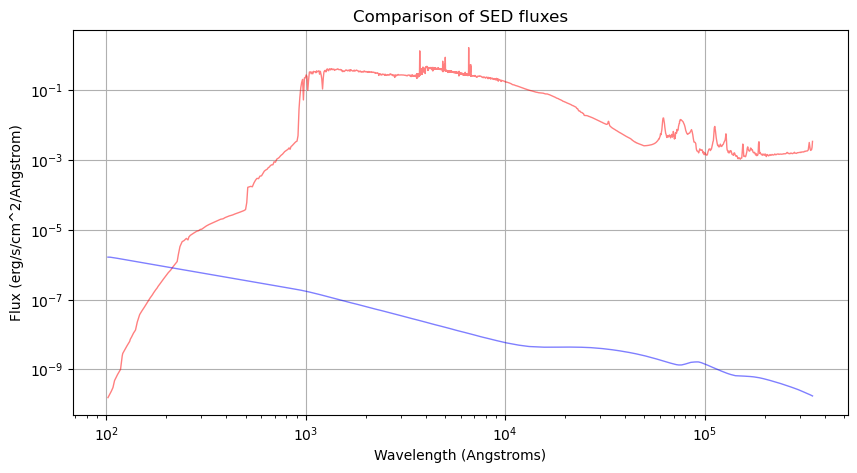

In [12]:
# We use our function two change the wavelenth range of the two SEDs, rectifying any missing wavelength values
ngc0337_template, agn_model = adjust_wavelength_range(ngc0337_template, agn_model)

# We can now attempt to replot these both on the same graph
wl_m82 = ngc0337_template['lambda (Angstroms)']
fl_m82 = ngc0337_template['Total Flux (erg/s/cm^2/Angstrom)']
wl_agn = agn_model['lambda (Angstroms)']
fl_agn = agn_model['Total Flux (erg/s/cm^2/Angstrom)']


# Plotting the adjusted SEDS
plt.figure(figsize=(10, 5))
plt.loglog(wl_m82, fl_m82, color='red', linewidth=1, linestyle='-', alpha=0.5)
plt.loglog(wl_agn, fl_agn, color='blue', linewidth=1, linestyle='-', alpha=0.5)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
plt.title('Comparison of SED fluxes')
plt.grid()
plt.show()

Creating composite with alpha = 0


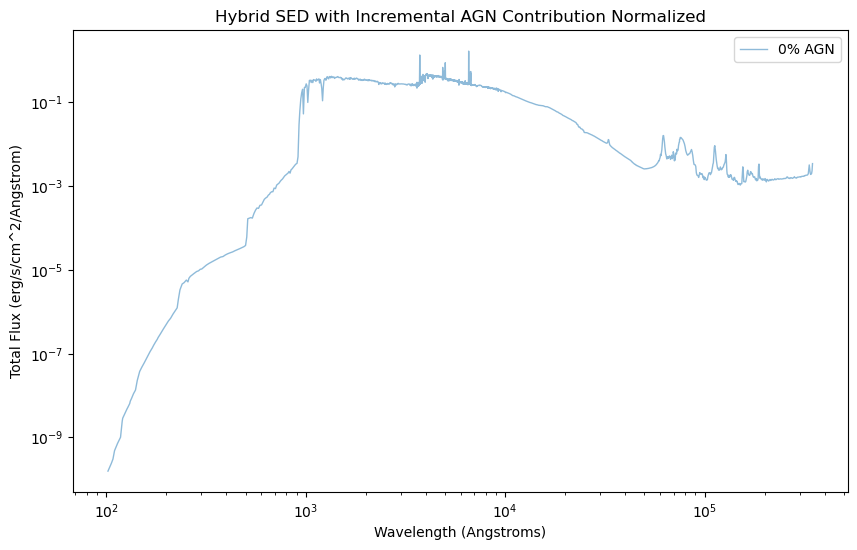

In [14]:
# Creating many composites
alpha = np.linspace(0, 1, 11) # 0% to 100% AGN
composites = []
for a in alpha:
    print(f'Creating composite with alpha = {a}')
    composite_galaxy = create_gal_agn_composite_sed(agn_model, ngc0337_template, a, 1)
    composites.append(composite_galaxy)
    

# Plotting the adjusted SEDS
plt.figure(figsize=(10, 6))
for i, comp in enumerate(composites):
    wl_comp = comp['lambda (Angstroms)']
    fl_comp = comp['Total Flux (erg/s/cm^2/Angstrom)']
    plt.loglog(wl_comp, fl_comp, linewidth=1, linestyle='-', alpha=0.5, label=f'{round(alpha[i]*100)}% AGN')
plt.legend()
plt.title("Hybrid SED with Incremental AGN Contribution Normalized")
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Total Flux (erg/s/cm^2/Angstrom)')
plt.show()

## Type 1 AGN +GALSEDATLAS Composites
Now we see that using the exact same approach from the swire templates we can also safely create composite galaxies using the GALSEDATLAS templates. This is a good sign that the code is working as intended and can be used to create composite galaxies from any SED template set. We will now read in all of the GALSEDATLAS templates and create a set of composite galaxy using the Type 1 AGN templates.

Tau: 7, p: 0.5, q: 0, oa: 50, rr: 20, i: 0


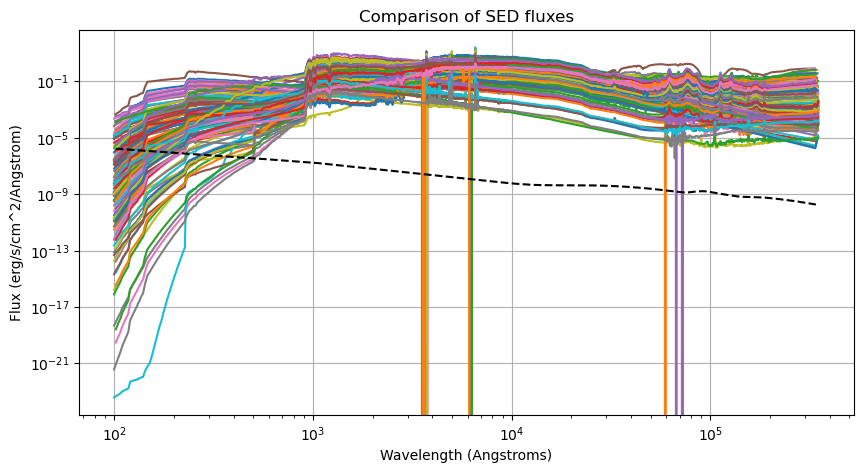

In [15]:
# Define the particular AGN Model we are exploring
# # 1. Type 1 AGN
tau = SKIRTOR_PARAMS['tau'][2]
p = SKIRTOR_PARAMS['p'][1] # Can make this either 0.5 or 0 (we choose 0.5)
q = SKIRTOR_PARAMS['q'][0] # Make this zero, similar to the Ciesla paper
oa = SKIRTOR_PARAMS['oa'][4] # opening angle of 50 degrees
rr = SKIRTOR_PARAMS['rr'][1] # ratio of 20
i = SKIRTOR_PARAMS['i'][0] # inclination of 0 degrees


# This is again, a new model
agn_model = read_skirtor_model(skirtor_folderpath, tau, p, q, oa, rr, i)

# Print the parameters used in the AGN model
print(f'Tau: {tau}, p: {p}, q: {q}, oa: {oa}, rr: {rr}, i: {i}')

# For completeness we will try to read in all of the galsedatlas templates 
# if this gives bad results we will selectively choose a large section of these templates
# read in all the template names
galsedatlas_templates, objname_list = read_brown_galaxy_templates(brown_folderpath)

# Make sure AGN are correctly scaled against the galaxy range   
# Have an original AGN model to adjust against 
type_1_agn = agn_model.copy()
type1agn_models = []


# When adjusting, we need to make sure we interpolate the data correctly at each point, 
# so for a specific AGN model this needs to be interpolated correctly against the relevant galaxy template
# essentially each AGN model will be specifically cut for it's template.
for i, template in enumerate(galsedatlas_templates):
    galsedatlas_templates[i], agn_model = adjust_wavelength_range(template, agn_model)   
    type1agn_models.append(agn_model)
    agn_model = type_1_agn.copy()


# Using the same alpha as before, we can create a composite of the AGN and the galaxy
# Use this as a comparison, but in actuality each AGN model will be adjusted to the specific galaxy template
wl_agn = type1agn_models[0]['lambda (Angstroms)']
fl_agn = type1agn_models[0]['Total Flux (erg/s/cm^2/Angstrom)']


plt.figure(figsize=(10, 5))
for i, template in enumerate(galsedatlas_templates):
    wl = template['lambda (Angstroms)']
    fl = template['Total Flux (erg/s/cm^2/Angstrom)']
    plt.loglog(wl, fl, label=objname_list[i])
plt.loglog(wl_agn, fl_agn, label='Type 1 AGN', color='black', linestyle='--')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
plt.title('Comparison of SED fluxes')
plt.grid()
#plt.legend()
plt.show()

# From inspection we see a huge amount of issues here, in particular the incredibly small flux values for some of the templates
# These may need to be removed, or a random subset of the templates may need to be chosen

In [16]:
alpha = np.linspace(0, 1, 11)
n = 8

# Creating many composites 
composites = []
for a in alpha:
    print(f'Creating composite with alpha = {a}')
    composite_galaxy = create_gal_agn_composite_sed(type1agn_models[n], galsedatlas_templates[n], a, 1)
    composites.append(composite_galaxy)
    
    

Creating composite with alpha = 0


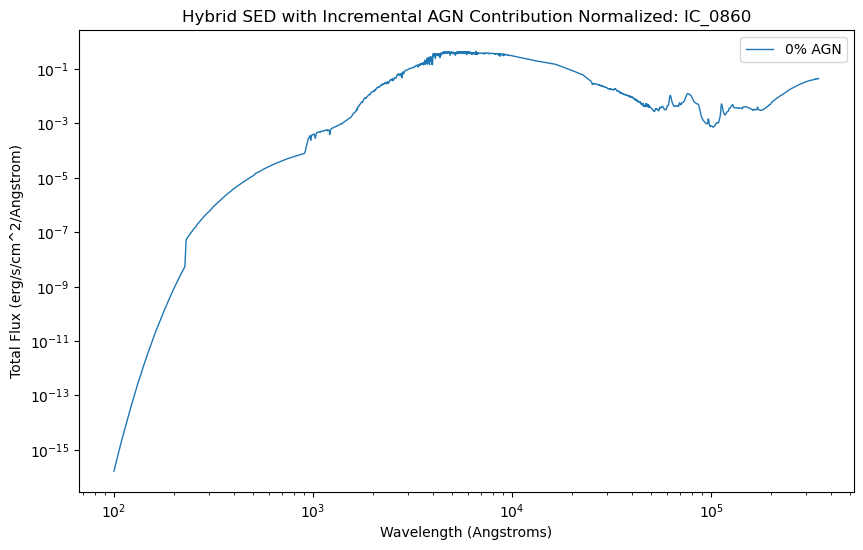

In [17]:

# Plotting the adjusted SEDS
plt.figure(figsize=(10, 6))
for i, comp in enumerate(composites):
    wl_comp = comp['lambda (Angstroms)']
    fl_comp = comp['Total Flux (erg/s/cm^2/Angstrom)']
    plt.loglog(wl_comp, fl_comp, linewidth=1, linestyle='-', label=f'{round(alpha[i]*100)}% AGN')
plt.legend()
plt.title("Hybrid SED with Incremental AGN Contribution Normalized: " + objname_list[n])
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Total Flux (erg/s/cm^2/Angstrom)')
plt.show()


In [18]:
# Now we know this is effective, we do the same thing on the GALSEDATLAS full template set
spacing = 11
alpha = np.linspace(0, 1, spacing)
type1composites = []

# So for every GALSEDATLAS template we will create a composite with the AGN model
for i, template in enumerate(galsedatlas_templates):
    print(f'Creating composite for {objname_list[i]}')
    agn_model = type1agn_models[i]
    type1composite_list = []
    for a in alpha:
        composite_galaxy = create_gal_agn_composite_sed(agn_model, template, a, 1)
        type1composite_list.append(composite_galaxy)
    type1composites.append(type1composite_list)
    

Creating composite for Arp_118
Creating composite for Arp_256_N
Creating composite for Arp_256_S
Creating composite for CGCG_049-057
Creating composite for CGCG_436-030
Creating composite for CGCG_453-062
Creating composite for Haro_06
Creating composite for IC_0691
Creating composite for IC_0860
Creating composite for IC_0883
Creating composite for IC_4051
Creating composite for IC_4553
Creating composite for IC_5298
Creating composite for III_Zw_035
Creating composite for II_Zw_096
Creating composite for IRAS_08572+3915
Creating composite for IRAS_17208-0014
Creating composite for Mrk_0331
Creating composite for Mrk_0475
Creating composite for Mrk_0930
Creating composite for Mrk_1450
Creating composite for Mrk_1490
Creating composite for Mrk_33
Creating composite for NGC_0337
Creating composite for NGC_0474
Creating composite for NGC_0520
Creating composite for NGC_0584
Creating composite for NGC_0628
Creating composite for NGC_0660
Creating composite for NGC_0695
Creating composite 

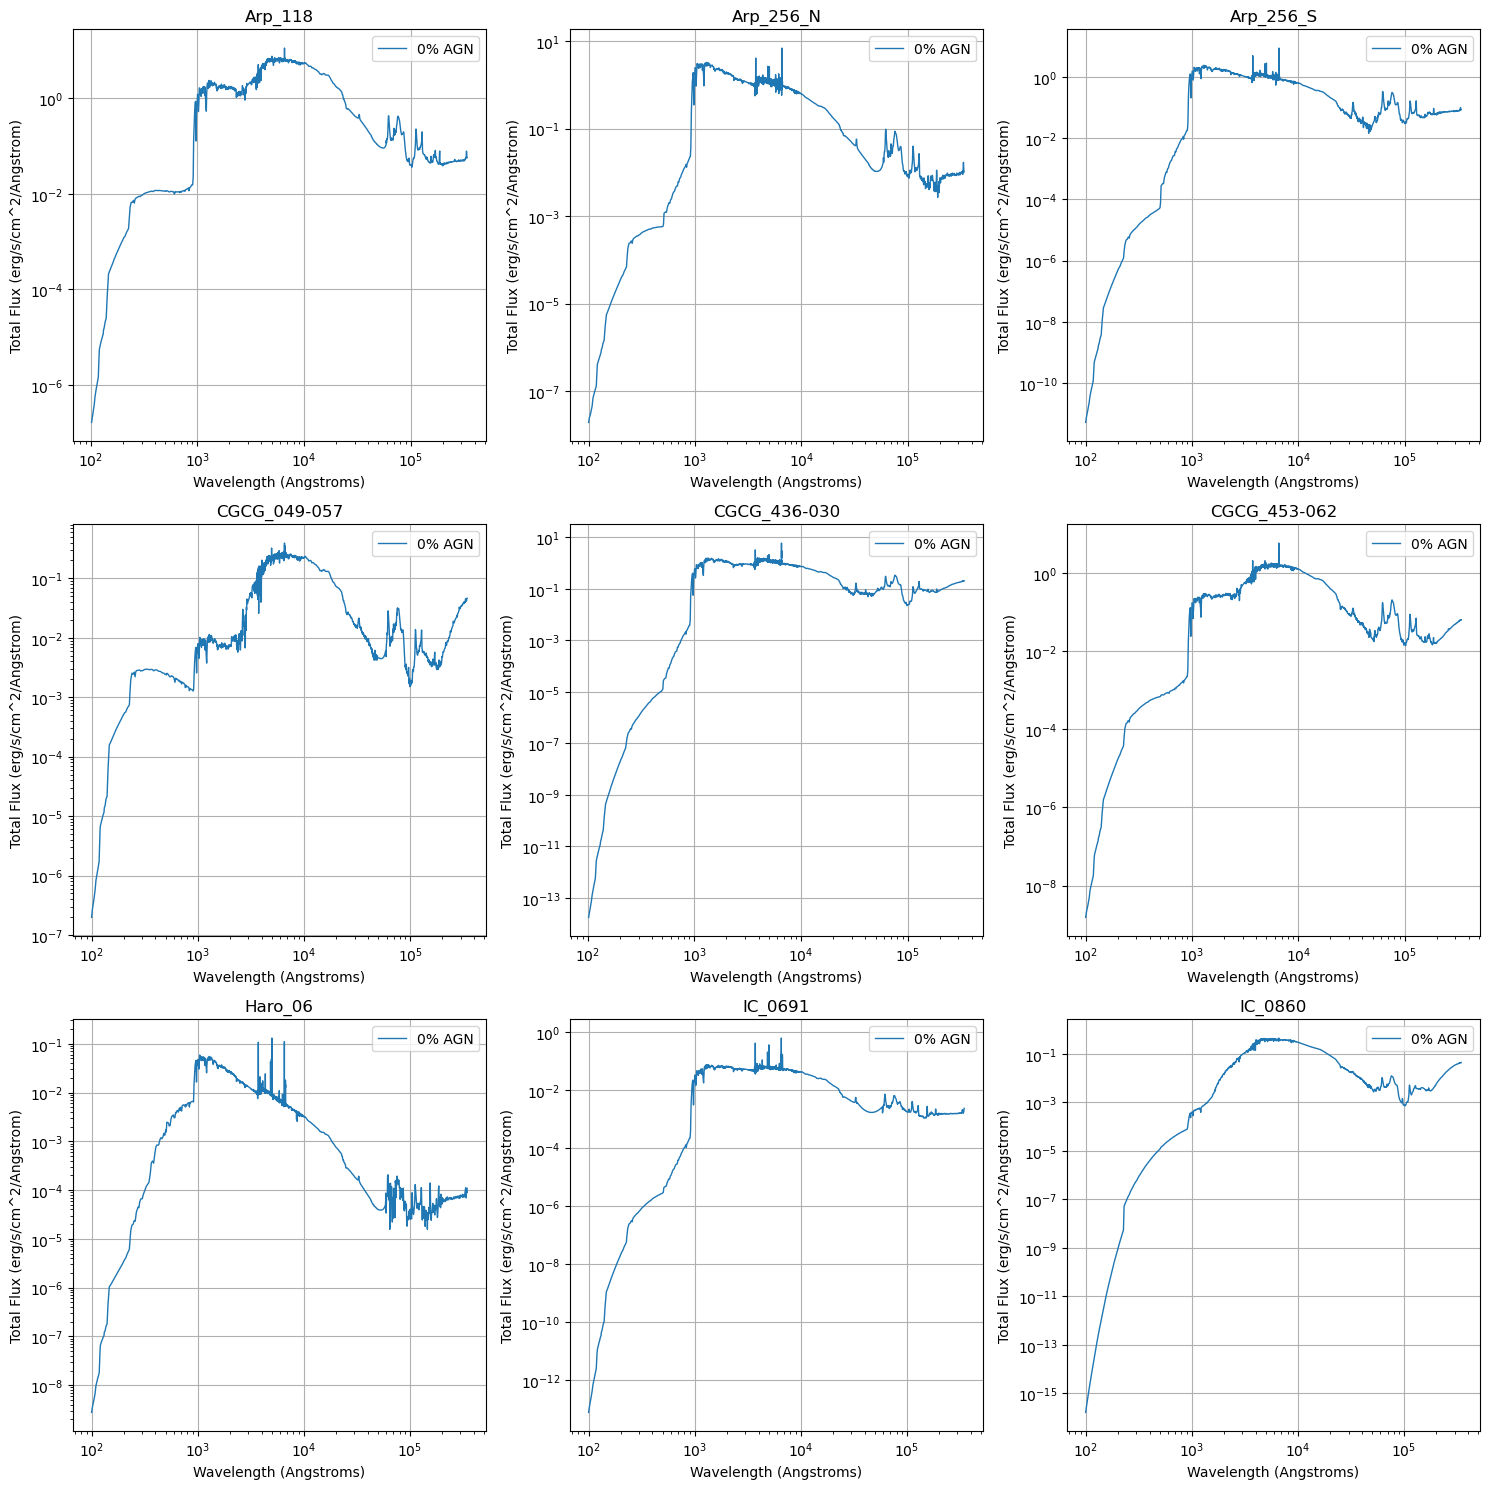

In [19]:
plt.figure(figsize=(15, 15))
# Do the first 9
for i in range(9):
    plt.subplot(3, 3, i+1)
    for j, comp in enumerate(type1composites[i]):
        wl_comp = comp['lambda (Angstroms)']
        fl_comp = comp['Total Flux (erg/s/cm^2/Angstrom)']
        plt.loglog(wl_comp, fl_comp, linewidth=1, linestyle='-', label=f'{round(alpha[j]*100)}% AGN')
    plt.legend()
    plt.title(objname_list[i])
    plt.xlabel('Wavelength (Angstroms)')
    plt.ylabel('Total Flux (erg/s/cm^2/Angstrom)')
    plt.grid()
    
plt.tight_layout()

# Save to outputs folder
plt.savefig('outputs/Type1AGNGALSEDATLASComposites.png', bbox_inches='tight', pad_inches=0.1, facecolor='white')

plt.show()

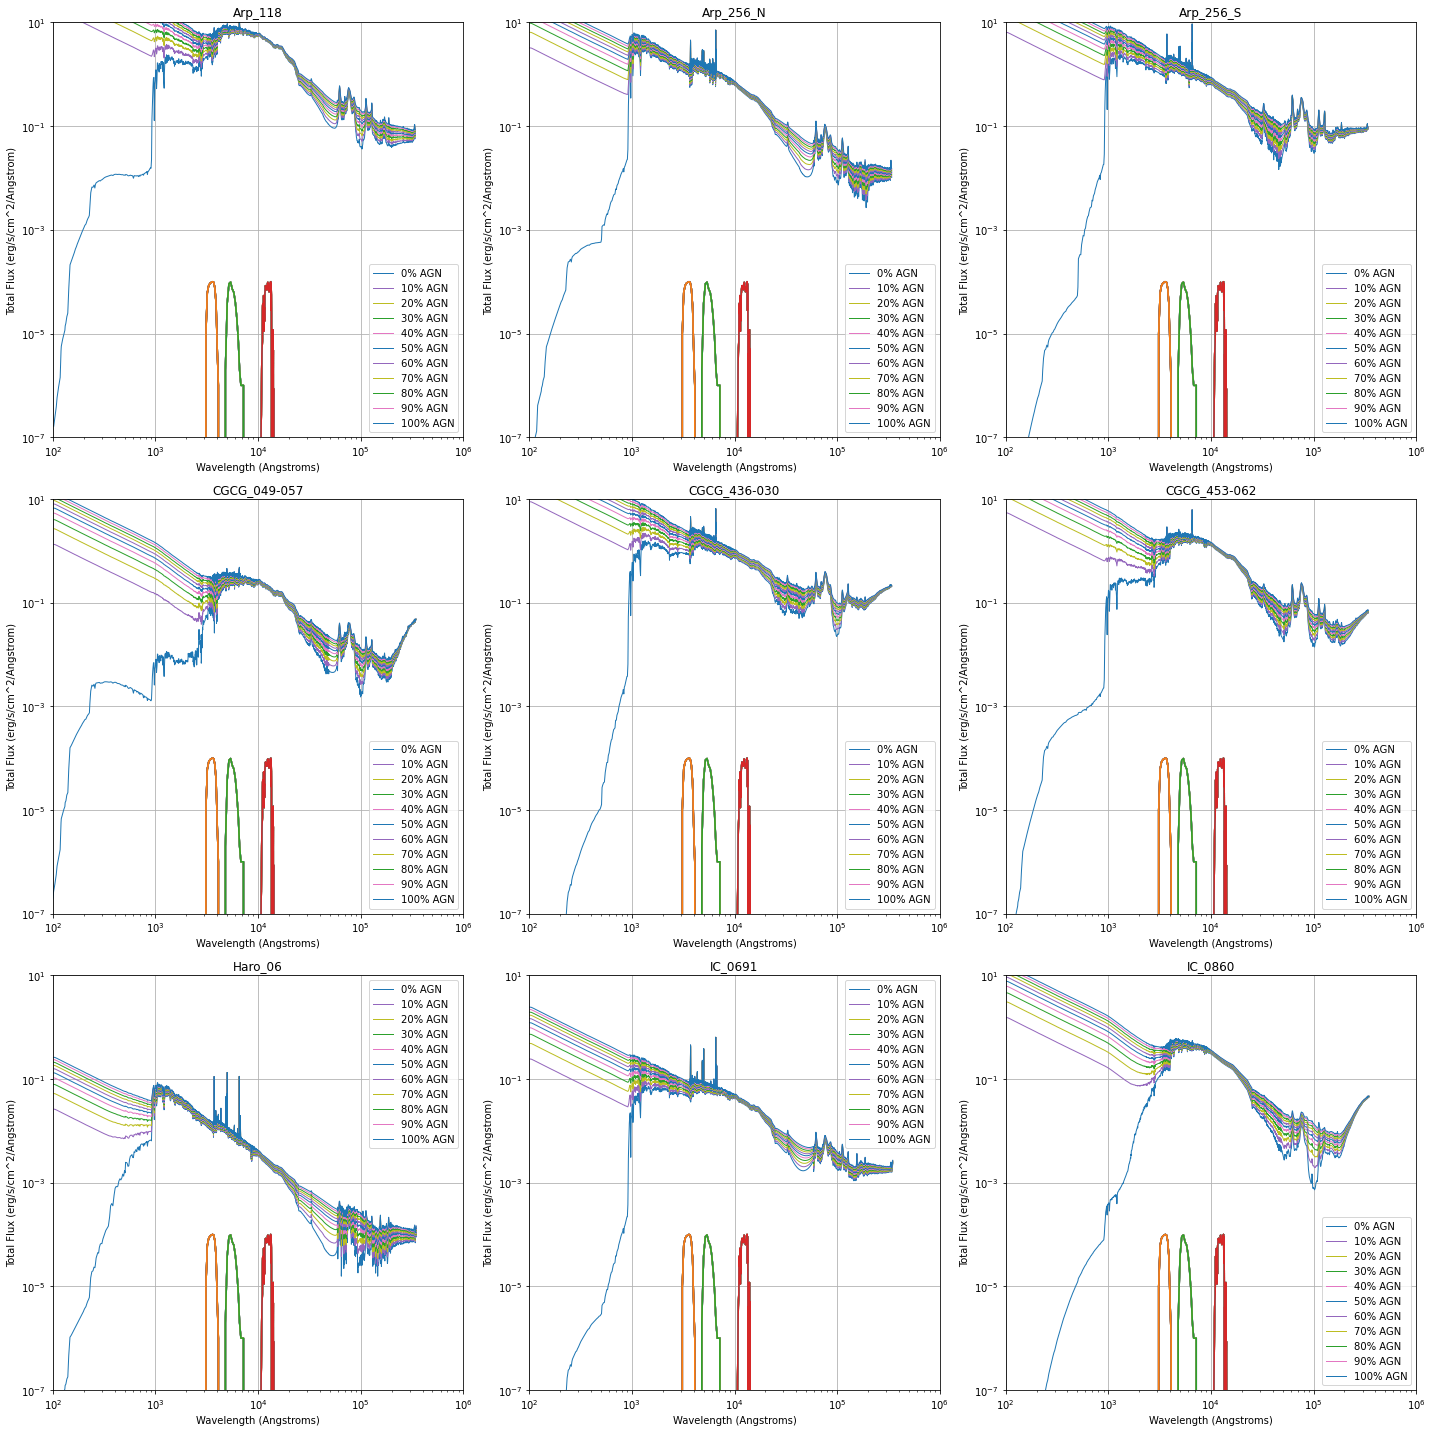

In [193]:
# To show that the short wavelength end is mostly inconsequential we plot the graph with scaled filters
# We can also plot the passbands for the UVJ
U_arr = np.array(pb_U.asList())
V_arr = np.array(pb_V.asList())
J_arr = np.array(pb_J.asList())
agn_type = 'Type1'
plt.figure(figsize=(20, 20))
sc = 1e-4
# Plot the SEDs

composites = type1composites

for i in range(9):
    plt.subplot(3, 3, i+1)
    for j, comp in enumerate(composites[i]):
        wl_comp = comp['lambda (Angstroms)']
        fl_comp = comp['Total Flux (erg/s/cm^2/Angstrom)']
        plt.loglog(wl_comp, fl_comp, linewidth=1, linestyle='-', label=f'{round(alpha[j]*100)}% AGN')
        plt.loglog(U_arr[:, 0], sc*U_arr[:,1])
        plt.loglog(V_arr[:, 0], sc*V_arr[:,1])
        plt.loglog(J_arr[:, 0], sc*J_arr[:,1])
    plt.legend()
    plt.title(objname_list[i])
    plt.xlabel('Wavelength (Angstroms)')
    plt.ylabel('Total Flux (erg/s/cm^2/Angstrom)')
    plt.grid()
    plt.xlim([1e2, 1e6])
    plt.ylim([1e-7, 1e1])



# plt.loglog(U_arr[:, 0], U_arr[:,1], label='U')
# plt.loglog(V_arr[:, 0], V_arr[:,1], label='V')
# plt.loglog(J_arr[:, 0], J_arr[:,1], label='J')
# plt.title("Passbands for the UVJ Filters")
# plt.xlabel('Wavelength (Angstroms)')
# plt.ylabel('Transmission')

# Set some limits


plt.tight_layout()

plt.savefig('outputs/'+str(agn_type)+'GALSEDATLASCompositessWithUVJFilters.png', bbox_inches='tight', pad_inches=0.1, facecolor='white')

plt.show()

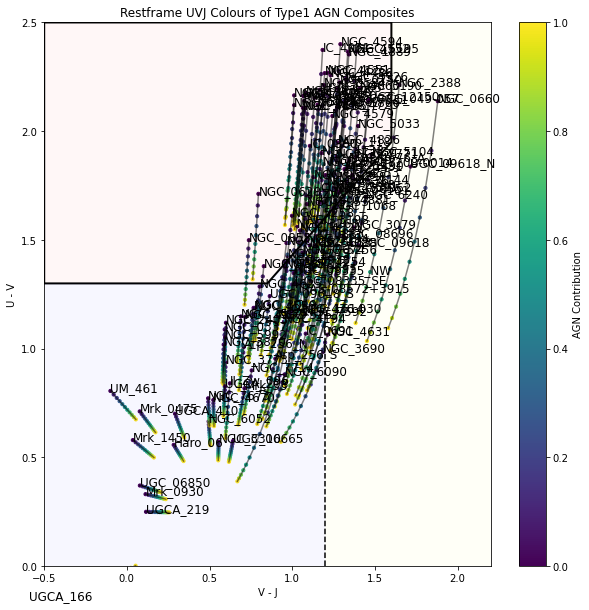

In [194]:



# We will do the UVJ proccessing in this section
uv_list = []
vj_list = []

        
# For each Type1 Composite, of verying values calculate the UVJ colours
# Setup a basic general composite list 

composites = type1composites
agn_type = 'Type1'

# Similar to before but plotting all of the composites on the same graph
uv_list = []
vj_list = []

# For each composite, calculate the UVJ colours for each alpha value
plt.figure(figsize=(10, 10))
for i in range(len(composites)):
    uv_list = []
    vj_list = []
    for j in range(len(alpha)):
        wl = composites[i][j].iloc[:, 0].values
        fl = composites[i][j].iloc[:, 1].values
        sed = astSED.SED(wavelength=wl, flux=fl) # z = 0.0 as these are restframe SEDs
        uv = astSED.SED.calcColour(sed, pb_U, pb_V, magType='AB')
        vj = astSED.SED.calcColour(sed, pb_V, pb_J, magType='AB')
        uv_list.append(uv)
        vj_list.append(vj)
        
        
    uv_colours = uv_list
    vj_colours = vj_list
    col = 'r'
    #plt.scatter(vj_colours, uv_colours, c=alpha, s=10, label="")
    # Plotting the colours, with the alpha values as the colour
    plt.scatter(vj_colours, uv_colours, c=alpha, s=10, label="")
    
    # Add a faint line to show the path of the composites
    plt.plot(vj_colours, uv_colours, alpha=0.5, color='black')
    
    # Add text to the first galaxy with no contribution of AGN, showing which SWIRE template is being used
    plt.text(vj_colours[0], uv_colours[0], objname_list[i], fontsize=12)
    
plt.ylabel('U - V')
plt.xlabel('V - J')
plt.title("Restframe UVJ Colours of "+ agn_type + " AGN Composites")
plt.xlim([-0.5, 2.2])
plt.ylim([0, 2.5])
plt.colorbar().set_label('AGN Contribution')
    
    # Define paths for selections
path_quiescent = [[-0.5, 1.3], [0.85, 1.3], [1.6, 1.95], [1.6, 2.5], [-0.5, 2.5]]
path_sf = [[-0.5, 0.0], [-0.5, 1.3], [0.85, 1.3], [1.2, 1.60333], [1.2, 0.0]]
path_sfd = [[1.2, 0.0], [1.2, 1.60333], [1.6, 1.95], [1.6, 2.5], [2.2, 2.5], [2.2, 0.0]]

# Add patches for selections
plt.gca().add_patch(plt.Polygon(path_quiescent, closed=True, fill=True, facecolor=(1, 0, 0, 0.03), edgecolor='k', linewidth=2, linestyle='solid'))
plt.gca().add_patch(plt.Polygon(path_sf, closed=True, fill=True, facecolor=(0, 0, 1, 0.03)))
plt.gca().add_patch(plt.Polygon(path_sfd, closed=True, fill=True, facecolor=(1, 1, 0, 0.03)))

# Add vertical line
plt.axvline(1.2, color='black', linestyle='--', ymin=0, ymax=1.60333/2.5)

# Save to outputs folder
plt.savefig('outputs/'+agn_type+'GALSEDATLASAGNUVJ.png', bbox_inches='tight', pad_inches=0.1, facecolor='white')

plt.show()



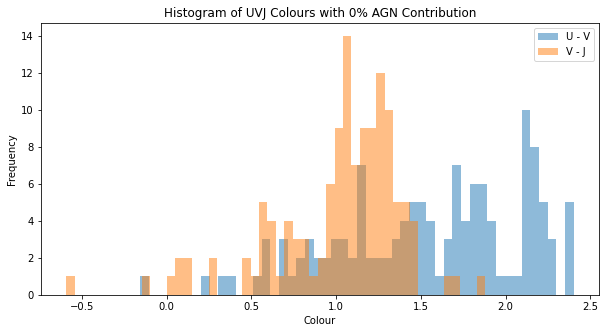

In [195]:
# Plot a histogram of the UVJ colours with 0 AGN contribution
# Generate UVJ colours for the first alpha value (0% AGN contribution)
uv_list0 = []
vj_list0 = []
for i in range(len(composites)):
    wl = composites[i][0].iloc[:, 0].values
    fl = composites[i][0].iloc[:, 1].values
    sed = astSED.SED(wavelength=wl, flux=fl) # z = 0.0 as these are restframe SEDs
    uv = astSED.SED.calcColour(sed, pb_U, pb_V, magType='AB')
    vj = astSED.SED.calcColour(sed, pb_V, pb_J, magType='AB')
    uv_list0.append(uv)
    vj_list0.append(vj)
    

plt.figure(figsize=(10, 5))
plt.hist(uv_list0, bins=50, alpha=0.5, label='U - V')
plt.hist(vj_list0, bins=50, alpha=0.5, label='V - J')
plt.xlabel('Colour')
plt.ylabel('Frequency')
plt.title("Histogram of UVJ Colours with 0% AGN Contribution")
plt.legend()
plt.show()

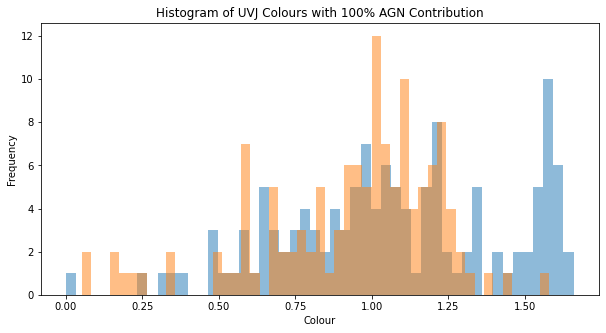

In [196]:
# Generate UVJ colours for 100% AGN contribution
uv_list = []
vj_list = []

for i in range(len(composites)):
    wl = composites[i][-1].iloc[:, 0].values
    fl = composites[i][-1].iloc[:, 1].values
    sed = astSED.SED(wavelength=wl, flux=fl) # z = 0.0 as these are restframe SEDs
    uv = astSED.SED.calcColour(sed, pb_U, pb_V, magType='AB')
    vj = astSED.SED.calcColour(sed, pb_V, pb_J, magType='AB')
    uv_list.append(uv)
    vj_list.append(vj)
    
# Plot the histogram of the UVJ colours
plt.figure(figsize=(10, 5))
plt.hist(uv_list, bins=50, alpha=0.5, label='U - V')
plt.hist(vj_list, bins=50, alpha=0.5, label='V - J')
plt.xlabel('Colour')
plt.ylabel('Frequency')
plt.title("Histogram of UVJ Colours with 100% AGN Contribution")
plt.show()

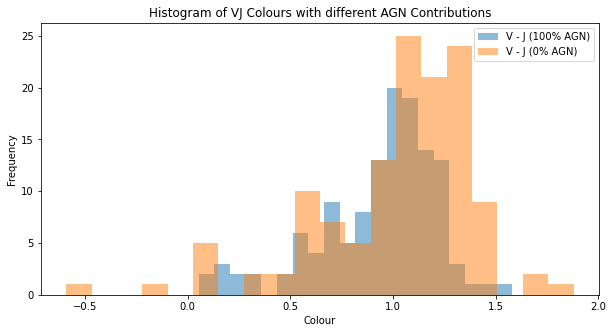

In [197]:
# Plot two histograms, one for the UV and one for the VJ colours
# comparing the distribution of UV and VJ colours for 0% and 100% AGN contribution
plt.figure(figsize=(10, 5))
plt.hist(vj_list, bins=20, alpha=0.5, label='V - J (100% AGN)')
plt.hist(vj_list0, bins=20, alpha=0.5, label='V - J (0% AGN)')
plt.xlabel('Colour')
plt.ylabel('Frequency')
plt.title("Histogram of VJ Colours with different AGN Contributions")
plt.legend()
plt.show()

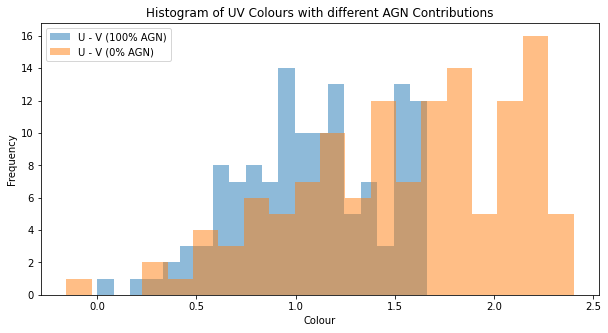

In [198]:
plt.figure(figsize=(10, 5))
plt.hist(uv_list, bins=20, alpha=0.5, label='U - V (100% AGN)')
plt.hist(uv_list0, bins=20, alpha=0.5, label='U - V (0% AGN)')
plt.xlabel('Colour')
plt.ylabel('Frequency')
plt.title("Histogram of UV Colours with different AGN Contributions")
plt.legend()
plt.show()

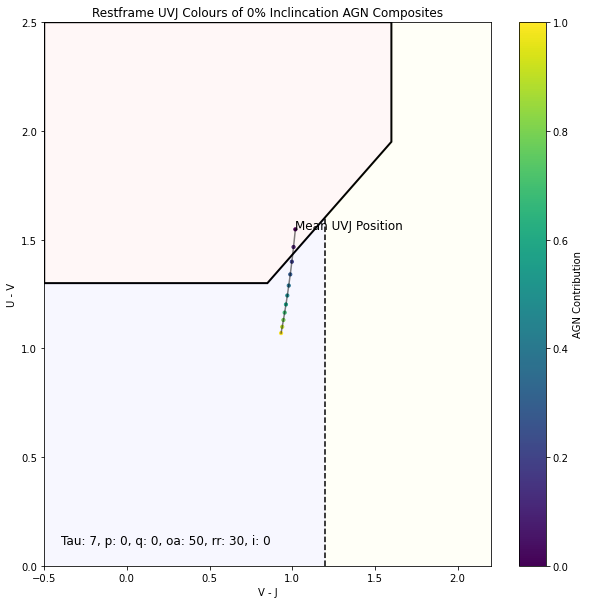

In [199]:
# We also use the mean position method to derive a mean position of all composites at a particular alpha value
plt.figure(figsize=(10, 10))

# For each inclination we would like to look at the alpha value, 
# For each alpha value, check each galaxy, and calculate the UVJ colours
# get a mean value of the UVJ colours for each alpha value, and plot it
# then move to the next alpha value

uv_mean = []
vj_mean = []

type1agn_uv = []
type1agn_vj = []

type1agn_uv_100 = []
type1agn_vj_100 = []

comp_inc_list = type1composites

for j in range(len(alpha)):
    # Calculate the UVJ colours for all of the composites and then average the position
    uv_list = []
    vj_list = []
    for i in range(len(objname_list)):
        wl = type1composites[i][j].iloc[:, 0].values
        fl = type1composites[i][j].iloc[:, 1].values
        sed = astSED.SED(wavelength=wl, flux=fl)
        uv = astSED.SED.calcColour(sed, pb_U, pb_V, magType='AB')
        vj = astSED.SED.calcColour(sed, pb_V, pb_J, magType='AB')
        uv_list.append(uv)
        vj_list.append(vj)
    uv_colours = uv_list
    vj_colours = vj_list
    uv_mean.append(np.mean(uv_colours))
    vj_mean.append(np.mean(vj_colours))
    
    
plt.scatter(vj_mean, uv_mean, c=alpha, s=10, label="")
    
# add the connecting line
plt.plot(vj_mean, uv_mean, alpha=0.5, color='black')

# Add text to the first galaxy with no contribution of AGN, showing which SWIRE template is being used
plt.text(vj_mean[0], uv_mean[0], 'Mean UVJ Position', fontsize=12)
    
plt.ylabel('U - V')
plt.xlabel('V - J')
plt.title("Restframe UVJ Colours of "+ str(0) + "% Inclincation AGN Composites")
plt.xlim([-0.5, 2.2])
plt.ylim([0, 2.5])
plt.colorbar().set_label('AGN Contribution')
    
    # Define paths for selections
path_quiescent = [[-0.5, 1.3], [0.85, 1.3], [1.6, 1.95], [1.6, 2.5], [-0.5, 2.5]]
path_sf = [[-0.5, 0.0], [-0.5, 1.3], [0.85, 1.3], [1.2, 1.60333], [1.2, 0.0]]
path_sfd = [[1.2, 0.0], [1.2, 1.60333], [1.6, 1.95], [1.6, 2.5], [2.2, 2.5], [2.2, 0.0]]

# Add patches for selections
plt.gca().add_patch(plt.Polygon(path_quiescent, closed=True, fill=True, facecolor=(1, 0, 0, 0.03), edgecolor='k', linewidth=2, linestyle='solid'))
plt.gca().add_patch(plt.Polygon(path_sf, closed=True, fill=True, facecolor=(0, 0, 1, 0.03)))
plt.gca().add_patch(plt.Polygon(path_sfd, closed=True, fill=True, facecolor=(1, 1, 0, 0.03)))

# Add vertical line
plt.axvline(1.2, color='black', linestyle='--', ymin=0, ymax=1.60333/2.5)

# Add a textbox with the model params
plt.text(-0.4, 0.1, f'Tau: {tau}, p: {p}, q: {q}, oa: {oa}, rr: {rr}, i: {0}', fontsize=12)

# Save to outputs folder
plt.savefig('outputs/UVJPlots/meanposition_composite_full_GALSEDATLAS_i_AGNUVJ.png', bbox_inches='tight', pad_inches=0.1, facecolor='white')

plt.show()

## Type 2 AGN + GALSEDATLAS Composites
Now we see that using the exact same approach from the swire templates we can also safely create composite galaxies using the GALSEDATLAS templates. Using the type 2 AGN templates we can create similar results

In [ ]:
# Define the particular AGN Model we are exploring
# # 1. Type 1 AGN
tau = SKIRTOR_PARAMS['tau'][2]
p = SKIRTOR_PARAMS['p'][1] # Can make this either 0.5 or 0 (we choose 0.5)
q = SKIRTOR_PARAMS['q'][0] # Make this zero, similar to the Ciesla paper
oa = SKIRTOR_PARAMS['oa'][4] # opening angle of 50 degrees
rr = SKIRTOR_PARAMS['rr'][1] # ratio of 20
i = SKIRTOR_PARAMS['i'][9] # inclination of 0 degrees

# This is again, a new model
agn_model = read_skirtor_model(skirtor_folderpath, tau, p, q, oa, rr, i)

# Print the parameters used in the AGN model
print(f'Tau: {tau}, p: {p}, q: {q}, oa: {oa}, rr: {rr}, i: {i}')

# For completeness we will try to read in all of the galsedatlas templates 
# if this gives bad results we will selectively choose a large section of these templates
# read in all the template names
galsedatlas_templates, objname_list = read_brown_galaxy_templates(brown_folderpath)

# Make sure AGN are correctly scaled against the galaxy range   
# Have an original AGN model to adjust against 
type_2_agn = agn_model.copy()
type2agn_models = []


# When adjusting, we need to make sure we interpolate the data correctly at each point, 
# so for a specific AGN model this needs to be interpolated correctly against the relevant galaxy template
# essentially each AGN model will be specifically cut for it's template.
for i, template in enumerate(galsedatlas_templates):
    galsedatlas_templates[i], agn_model = adjust_wavelength_range(template, agn_model)   
    type2agn_models.append(agn_model)
    agn_model = type_2_agn.copy()


# Using the same alpha as before, we can create a composite of the AGN and the galaxy
# Use this as a comparison, but in actuality each AGN model will be adjusted to the specific galaxy template
wl_agn = type1agn_models[0]['lambda (Angstroms)']
fl_agn = type1agn_models[0]['Total Flux (erg/s/cm^2/Angstrom)']


plt.figure(figsize=(10, 5))
for i, template in enumerate(galsedatlas_templates):
    wl = template['lambda (Angstroms)']
    fl = template['Total Flux (erg/s/cm^2/Angstrom)']
    plt.loglog(wl, fl, label=objname_list[i])
plt.loglog(wl_agn, fl_agn, label='Type 1 AGN', color='black', linestyle='--')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
plt.title('Comparison of SED fluxes')
plt.grid()
#plt.legend()
plt.show()

# From inspection we see a huge amount of issues here, in particular the incredibly small flux values for some of the templates
# These may need to be removed, or a random subset of the templates may need to be chosen

In [ ]:
# Now we know this is effective, we do the same thing on the GALSEDATLAS full template set
spacing = 11
alpha = np.linspace(0, 1, spacing)
type2composites = []

# So for every GALSEDATLAS template we will create a composite with the AGN model
for i, template in enumerate(galsedatlas_templates):
    print(f'Creating composite for {objname_list[i]}')
    agn_model = type2agn_models[i]
    type2composite_list = []
    for a in alpha:
        composite_galaxy = create_gal_agn_composite_sed(agn_model, template, a, 1)
        type2composite_list.append(composite_galaxy)
    type2composites.append(type1composite_list)

In [ ]:
plt.figure(figsize=(15, 15))
# Do the first 9
for i in range(9):
    plt.subplot(3, 3, i+1)
    for j, comp in enumerate(type2composites[i]):
        wl_comp = comp['lambda (Angstroms)']
        fl_comp = comp['Total Flux (erg/s/cm^2/Angstrom)']
        plt.loglog(wl_comp, fl_comp, linewidth=1, linestyle='-', label=f'{round(alpha[j]*100)}% AGN')
    plt.legend()
    plt.title(objname_list[i])
    plt.xlabel('Wavelength (Angstroms)')
    plt.ylabel('Total Flux (erg/s/cm^2/Angstrom)')
    plt.grid()
    
plt.tight_layout()

# Save to outputs folder
plt.savefig('outputs/Type2AGNGALSEDATLASComposites.png', bbox_inches='tight', pad_inches=0.1, facecolor='white')

plt.show()